In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
from scipy.special import factorial
import h5py
import copy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions')
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 27/04/2020 11:42:31


In [16]:
fm_num=8 # pick one mirror
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'
ca_resize = 80
diam_ca100 = 50*u.mm

for ns in range(0, tot_step):
    print('Analyzing Step {0}'.format(ns))
    # call in the file
    fm_loc = 'flat_mirrors/2018_03_23/flat_2in_n{0}_100percent_step{1}.datx'.format(fm_num, ns)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=50*u.mm)
    wavelen = sp['value'][sp['label'].index('wavelen')]

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)
    
    # apply a resize
    ca_side = np.int(np.shape(mask)[0]*ca_resize/100)
    if ca_side % 2 !=0: # check resize is even, required by PSD code
        if ca_resize < 100: 
            ca_side += 1 # increase by 1 - better to have more
        else:
            ca_side -= 1 # if looking at 100% CA
    ca_reduce = np.shape(mask)[0] - ca_side
    if ca_reduce > 0:
        surf, mask = dfx.mat_reduce(surf, mask, side_reduce = ca_reduce)

    # save the raw file
    raw_file = fits_folder+'flat_2in_ca{0}_n{1}_step{2}_raw'.format(ca_resize, fm_num, ns)
    #dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=raw_file, save_mask=False)

    #Convert surface data to phase'
    k_num = wavelen.to(surf.unit) / (2*np.pi*u.radian)
    surf_phase = surf / k_num
    
    # remove up to zernike 9
    z_weight = []
    surf_fix_phase = copy.copy(surf_phase) # intitialize 
    zn = [0, 1, 2, 3]
    for nv in zn:
        zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
        for mv in zm:
            #print('Correcting zernike n={0} m={1}'.format(nv, mv))
            z_phase, w_val = zern.calc_zernike_proj(data=surf_phase, mask=mask, zn=nv, zm=mv)
            surf_fix_phase = surf_fix_phase - (z_phase*w_val)
            z_weight.append(w_val)

    # change the surface back into units of OPD
    surf_fix = surf_fix_phase * k_num
    
    # write data to a matrix
    if ns==0: # initialize first time
        data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize first
    data_set[ns, :, :] = surf_fix.value

    # write all this to a FITS file
    fits_file = fits_folder+'flat_2in_ca{0}_n{1}_step{2}'.format(ca_resize, fm_num, ns)
    #dfx.write_fits(surface=surf_fix, mask=mask, surf_parms=sp, filename=fits_file)

# apply units to the data set
data_set *= surf_fix.unit

Analyzing Step 0
Analyzing Step 1
Analyzing Step 2
Analyzing Step 3
Analyzing Step 4
Analyzing Step 5


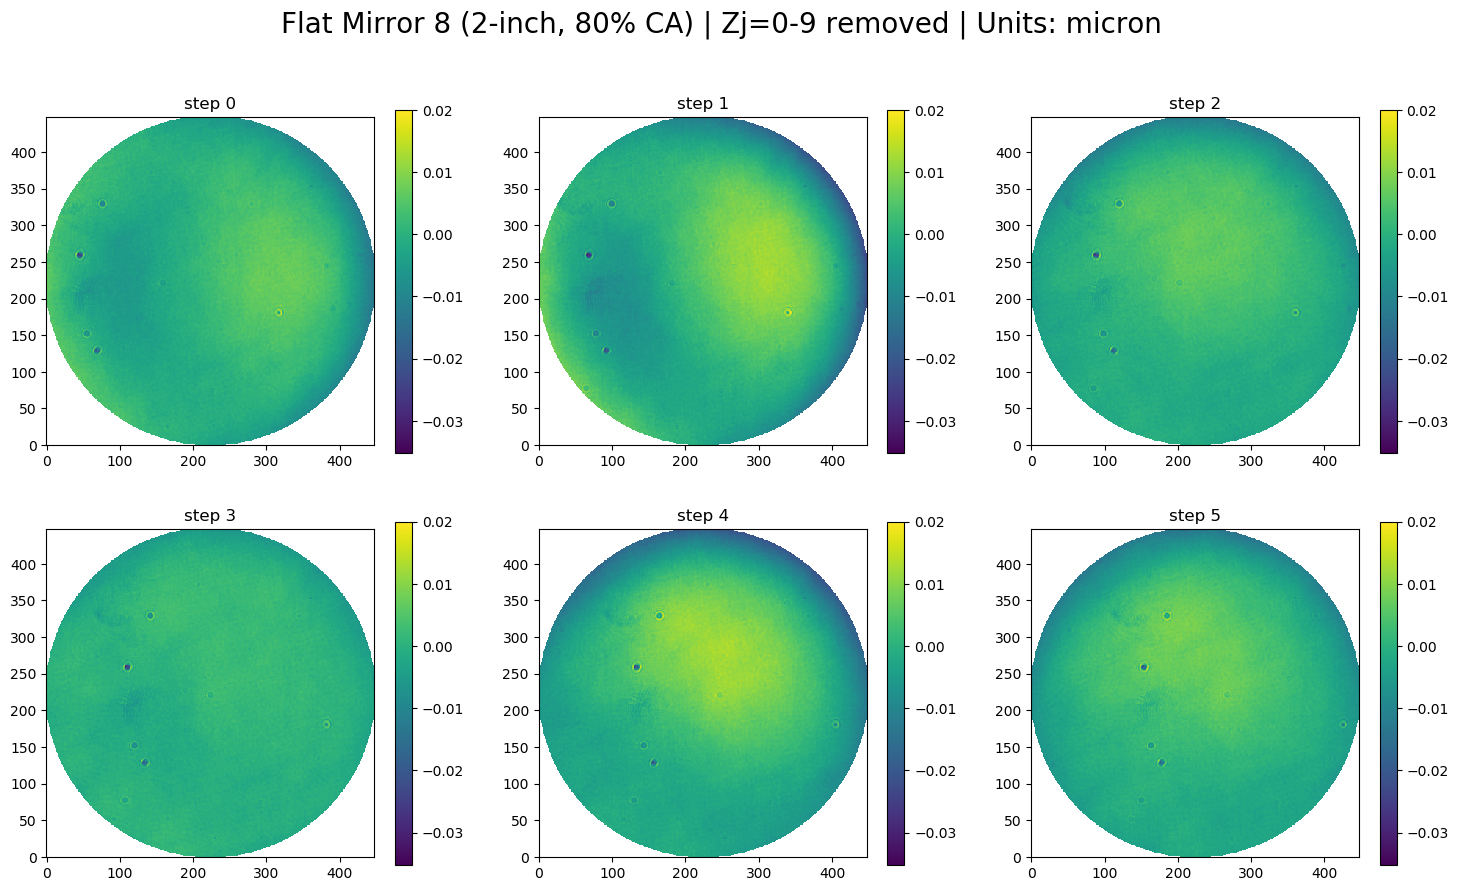

In [19]:
# calc min and max
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

plt.figure(figsize=[18, 10], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(ca_resize, data_set[0].unit), fontsize=20)
for n in range(0,tot_step):  
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(data_set[n].value,mask), origin='lower', vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

In [9]:
# generate the median data
# flatten the data
flat_data = np.zeros((tot_step, np.product(np.shape(mask))))
for n in range(0, tot_step):
    flat_data[n] = np.reshape(data_set[n],np.product(np.shape(mask)))
# now calculate the median
med_data = np.median(flat_data, axis=0).reshape(np.shape(mask))
med_file = fits_folder+'flat_2in_ca{0}_n{1}_median'.format(ca_resize, fm_num)
dfx.write_fits(surface=med_data, mask=mask, surf_parms=sp, filename=med_file)

Text(0.5, 1.0, 'Median data (micron)')

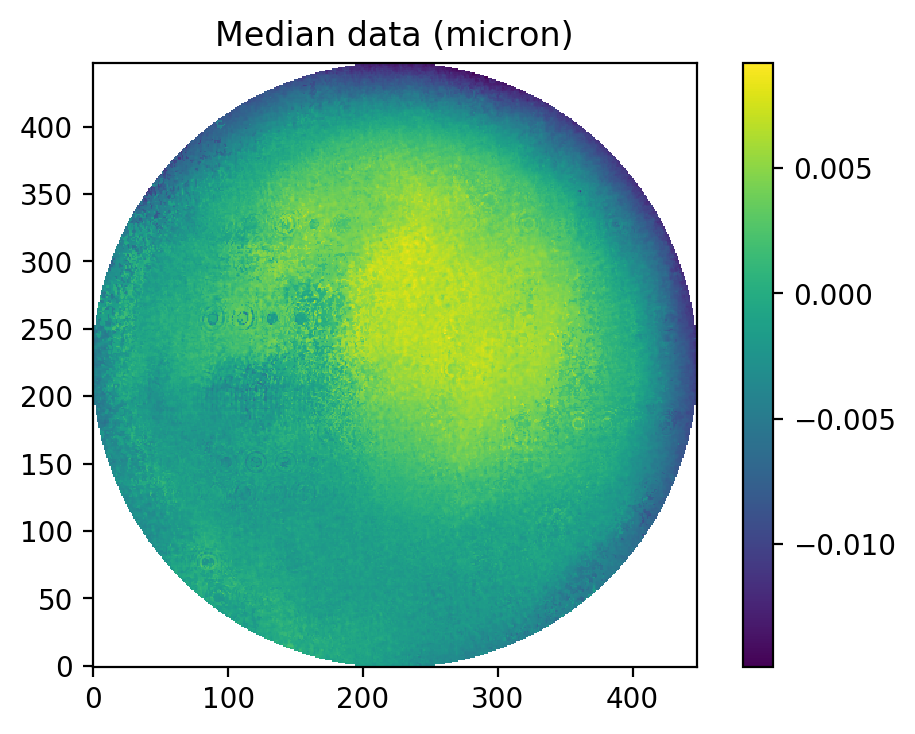

In [175]:
# show the plot of the median data
plt.figure( dpi=200)
plt.imshow(dfx.sn_map(med_data,mask), origin='lower')
plt.colorbar()
plt.title('Median data ({0})'.format(data_set.unit))

## Single dust masking

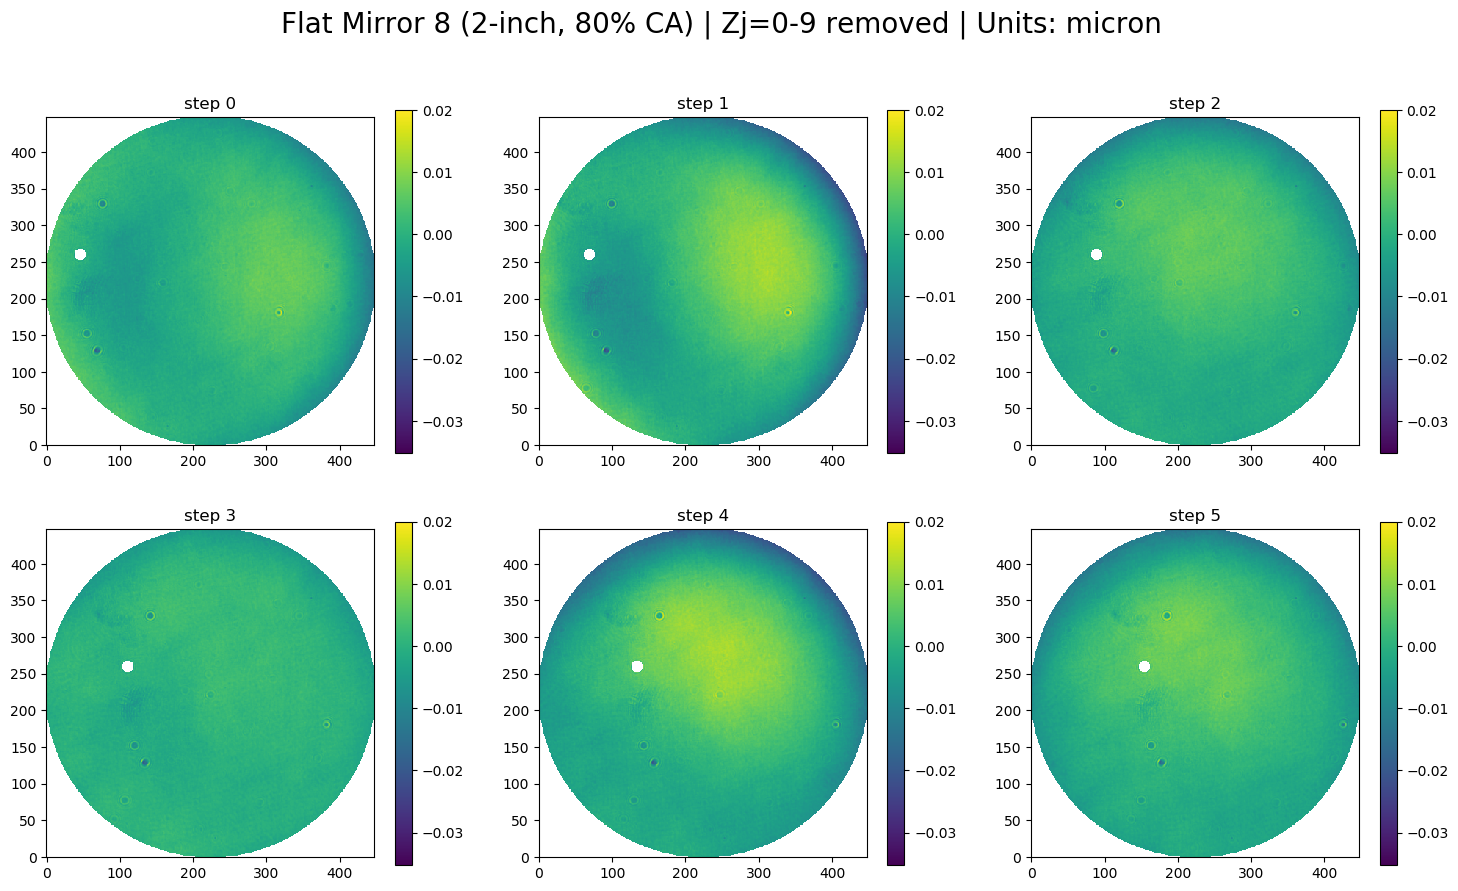

In [194]:
test_data = copy.copy(data_set)
dust_center = [ (46, 259), (68, 259), (89, 259), (111, 259), (133, 259), (154, 259)]
dust_radius=8

mask_sum = np.ones_like(mask)

for n in range(0, len(dust_center)):
    mask_step = np.ones_like(mask)
    dmc = np.zeros_like(mask)
    dm_coord = draw.circle(r=dust_center[n][1], c=dust_center[n][0], radius=dust_radius)
    dmc[dm_coord] = True
    mask_step[dmc==True] = np.nan
    test_data[n] = data_set[n]*mask_step
    mask_sum*=mask_step

# calc min and max
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

plt.figure(figsize=[18, 10], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(ca_resize, data_set[0].unit), fontsize=20)
for n in range(0,tot_step):  
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(test_data[n].value,mask), origin='lower', vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

In [196]:
# generate the median data
# flatten the data
tflat = np.zeros((tot_step, np.product(np.shape(mask)))) # unbiased
flat_data = np.zeros((tot_step, np.product(np.shape(mask)))) # biased
for n in range(0, tot_step):
    tflat[n] = np.reshape(test_data[n],np.product(np.shape(mask)))
    flat_data[n] = np.reshape(data_set[n],np.product(np.shape(mask)))
# now calculate the median
mfnobias = np.zeros((np.product(np.shape(mask))))
mfbias = np.zeros((np.product(np.shape(mask))))
for k in range(0, np.product(np.shape(mask))):
    # unbiased data
    pix_data = tflat[:,k]
    pix_bin = pix_data[~np.isnan(pix_data)]
    mfnobias[k] = np.median(pix_bin)
    
    # biased data
    pix_data = flat_data[:,k]
    pix_bin = pix_data[~np.isnan(pix_data)]
    mfbias[k] = np.median(pix_bin)

# reshape    
med_nobias = mfnobias.reshape(np.shape(mask))
med_bias = mfbias.reshape(np.shape(mask))

# write the files
file_nobias = fits_folder+'flat_2in_ca{0}_n{1}_median_1dustbias'.format(ca_resize, fm_num)
dfx.write_fits(surface=med_nobias, mask=mask, surf_parms=sp, filename=file_nobias)

file_bias = fits_folder+'flat_2in_ca{0}_n{1}_median_bias'.format(ca_resize, fm_num)
dfx.write_fits(surface=med_bias, mask=mask, surf_parms=sp, filename=file_bias)

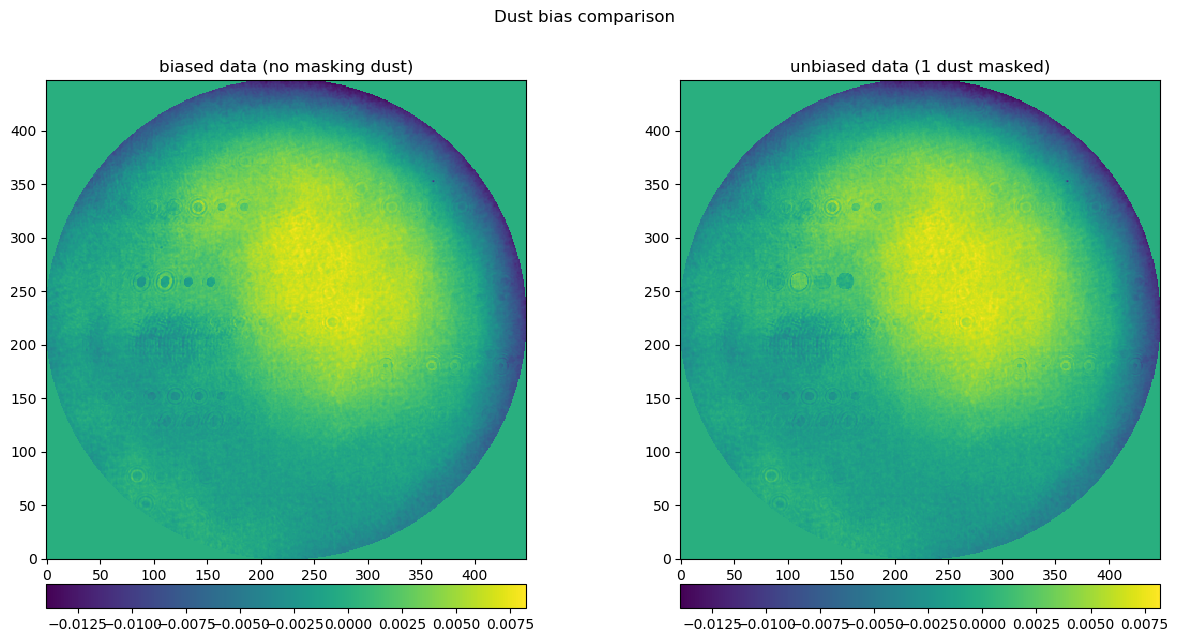

In [197]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = med_bias,
               plot1_label='biased data (no masking dust)',
               data2 = med_nobias,
               plot2_label='unbiased data (1 dust masked)',
               set_figsize=[15,7],
               set_dpi=100)

In [200]:
# generate the PSDs
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm, # not really useful but okay
             'surf_units': u.micron}

fits_folder = 'zygo_data/flat_mirrors/fixed_fits/'
fm_num = 8

# biased data
n_step = 'biased'
fm_bias = psd.surfPSD(surf_name = n_step, oversamp = opt_parms['ovs'])

# load the file
fm_bias.open_surf(fileloc=file_bias+'_surf.fits', surf_units = u.micron)
fm_bias.open_mask(fileloc=file_bias+'_mask.fits')
# fm_med_80 the PSD
fm_bias.calc_psd(oversamp = opt_parms['ovs'])
print('PSD for {0} complete'.format(n_step))

# calculate the radial profile
fm_bias.calc_psd_radial(ring_width=5)
print('Radial profile for {0} complete\n'.format(n_step))

# unbiased data
n_step = 'unbiased'
fm_nobias = psd.surfPSD(surf_name = n_step, oversamp = opt_parms['ovs'])

# load the file
fm_nobias.open_surf(fileloc=file_nobias+'_surf.fits', surf_units = u.micron)
fm_nobias.open_mask(fileloc=file_nobias+'_mask.fits')
# fm_med_80 the PSD
fm_nobias.calc_psd(oversamp = opt_parms['ovs'])
print('PSD for {0} complete'.format(n_step))

# calculate the radial profile
fm_nobias.calc_psd_radial(ring_width=5)
print('Radial profile for {0} complete\n'.format(n_step))

PSD for biased complete
Radial profile for biased complete

PSD for unbiased complete
Radial profile for unbiased complete



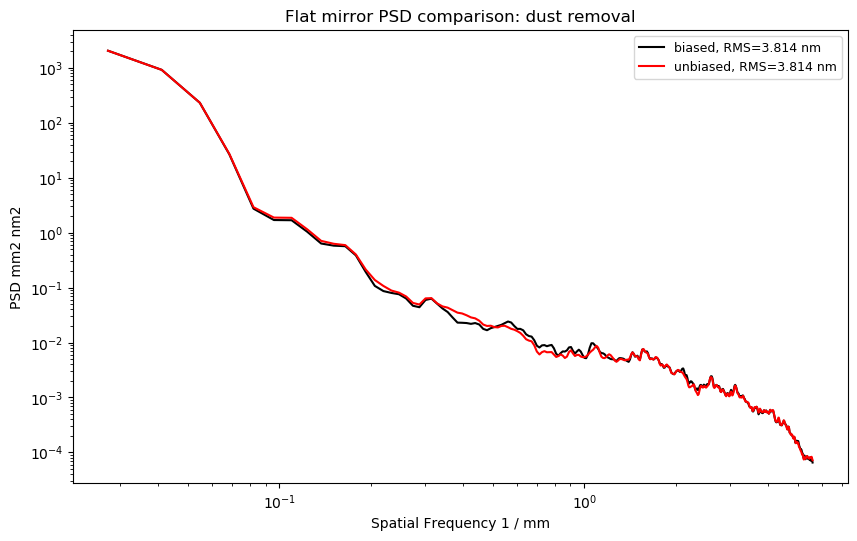

In [201]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, np.sqrt(fm_bias.var)))
plt.loglog(fm_nobias.k_radial.value, fm_nobias.psd_radial_cal.value, 'r', label='{0}, RMS={1:.3f}'.format(fm_nobias.surf_name, np.sqrt(fm_nobias.var)))
plt.xlabel('Spatial Frequency {0}'.format(fm_bias.k_radial.unit))
plt.ylabel('PSD {0}'.format(fm_bias.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

## Pixel Filtering

Text(0.5, 1.0, 'Dust pixel testing')

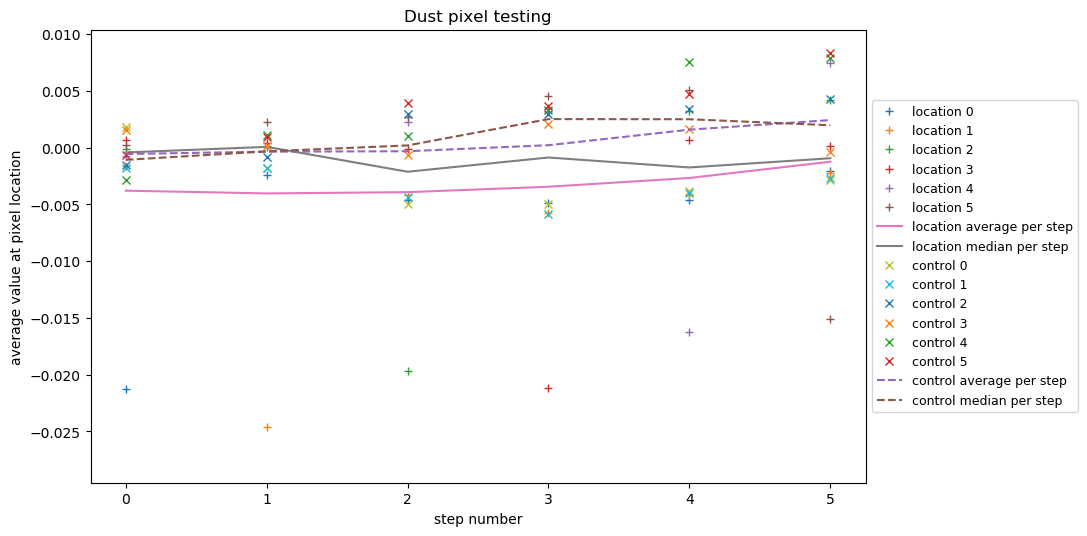

In [223]:
ddust = np.zeros((tot_step, tot_step))
ctrl = np.zeros((tot_step, tot_step))
ctrl_avg = np.zeros(tot_step)
ddust_avg = np.zeros(tot_step)
ctrl_med = np.zeros(tot_step)
ddust_med = np.zeros(tot_step)
ctrl_std = np.zeros(tot_step)
ddust_std = np.zeros(tot_step)
for n in range(0, len(dust_center)):
    for m in range(0, tot_step):
        ddust[m][n] = data_set[m][dust_center[n][1]][dust_center[n][0]].value
        ctrl[m][n] = data_set[m][dust_center[n][1]+10][dust_center[n][0]].value
    ctrl_bin = ctrl[:,n]
    ddust_bin = ddust[:,n]
    ctrl_avg[n] = np.mean(ctrl_bin)
    ddust_avg[n] = np.mean(ddust_bin)
    ctrl_med[n] = np.median(ctrl_bin)
    ddust_med[n] = np.median(ddust_bin)
    ctrl_std[n] = np.std(ctrl_bin)
    ddust_std[n] = np.std(ddust_bin)

vmax = np.amax([np.amax(ddust), np.amax(ctrl)])
vmin = np.amin([np.amin(ddust), np.amin(ddust)])

# plot the data
n_step = np.linspace(0, tot_step,tot_step, endpoint=False)
plt.figure(figsize=[10,6], dpi=100)
for n in range(0, tot_step):
    plt.plot(n_step, ddust[n], '+', label='location {0}'.format(n))
plt.plot(n_step, ddust_avg, label='location average per step')
plt.plot(n_step, ddust_med, label='location median per step')
for n in range(0, tot_step):
    plt.plot(n_step, ctrl[n], 'x', label='control {0}'.format(n))
plt.plot(n_step, ctrl_avg, '--', label='control average per step')
plt.plot(n_step, ctrl_med, '--', label='control median per step')
#plt.plot(n_step, ctrl_std, label='control std per step')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([vmin*1.2, vmax*1.25])
plt.xlabel('step number')
plt.ylabel('average value at pixel location')
plt.title('Dust pixel testing')

In [208]:
avg_surf_flat = np.zeros(np.product(np.shape(mask)))
med_surf_flat = np.zeros(np.product(np.shape(mask)))
for n in range(0, np.product(np.shape(mask))):
    x = flat_data[:,n]
    # set parameters
    rmax = np.mean(x) + (1*np.std(x))
    rmin = np.mean(x) - (1*np.std(x))
    out_ind = []
    for m in range(0, tot_step): # filter
        if x[m] < rmin or x[m] > rmax: # if outlier
            #x[m] = np.nan
            out_ind.append(m)
    if len(out_ind) != 0: # if outlier exists
        x = np.delete(x, out_ind)
    # take average and median of data
    avg_surf_flat[n] = np.mean(x)
    med_surf_flat[n] = np.median(x)
# reshape the matricies back
pix_med = np.reshape(med_surf_flat, np.shape(mask))
pix_avg = np.reshape(avg_surf_flat, np.shape(mask))

# write the files
fits_folder = 'flat_mirrors/fixed_fits/'
file_nobias_pix = fits_folder+'flat_2in_ca{0}_n{1}_median_pixbias'.format(ca_resize, fm_num)
dfx.write_fits(surface=pix_med, mask=mask, surf_parms=sp, filename=file_nobias_pix)

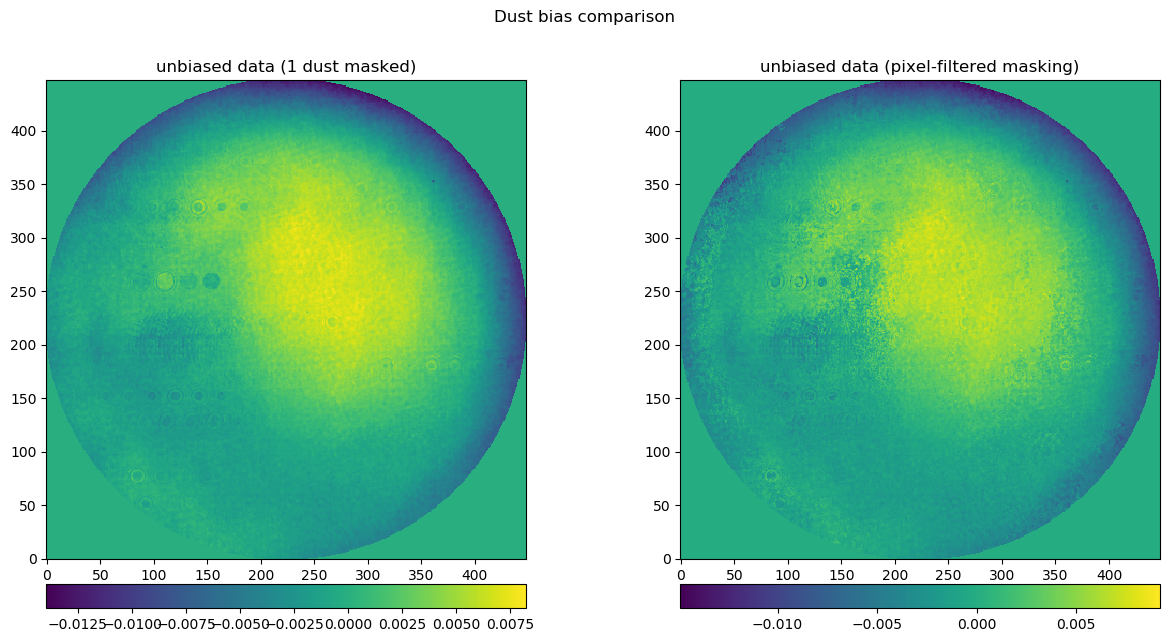

In [205]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = med_nobias,
               plot1_label='unbiased data (1 dust masked)',
               data2 = pix_med,
               plot2_label='unbiased data (pixel-filtered masking)',
               set_figsize=[15,7],
               set_dpi=100)

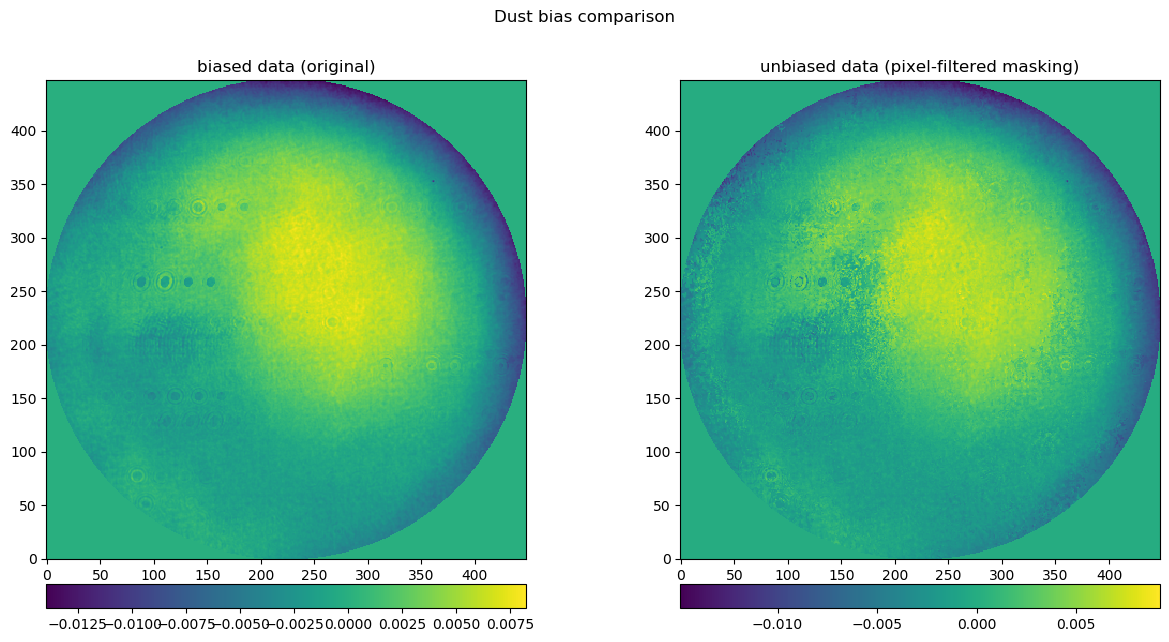

In [206]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = med_bias,
               plot1_label='biased data (original)',
               data2 = pix_med,
               plot2_label='unbiased data (pixel-filtered masking)',
               set_figsize=[15,7],
               set_dpi=100)

In [209]:
# unbiased data - pixel filtering
n_step = 'unbiased_pix_filter'
fm_nobias_pix = psd.surfPSD(surf_name = n_step, oversamp = opt_parms['ovs'])

# load the file
fm_nobias_pix.open_surf(fileloc=file_nobias_pix+'_surf.fits', surf_units = u.micron)
fm_nobias_pix.open_mask(fileloc=file_nobias_pix+'_mask.fits')
# fm_med_80 the PSD
fm_nobias_pix.calc_psd(oversamp = opt_parms['ovs'])
print('PSD for {0} complete'.format(n_step))

# calculate the radial profile
fm_nobias_pix.calc_psd_radial(ring_width=5)
print('Radial profile for {0} complete\n'.format(n_step))

PSD for unbiased_pix_filter complete
Radial profile for unbiased_pix_filter complete



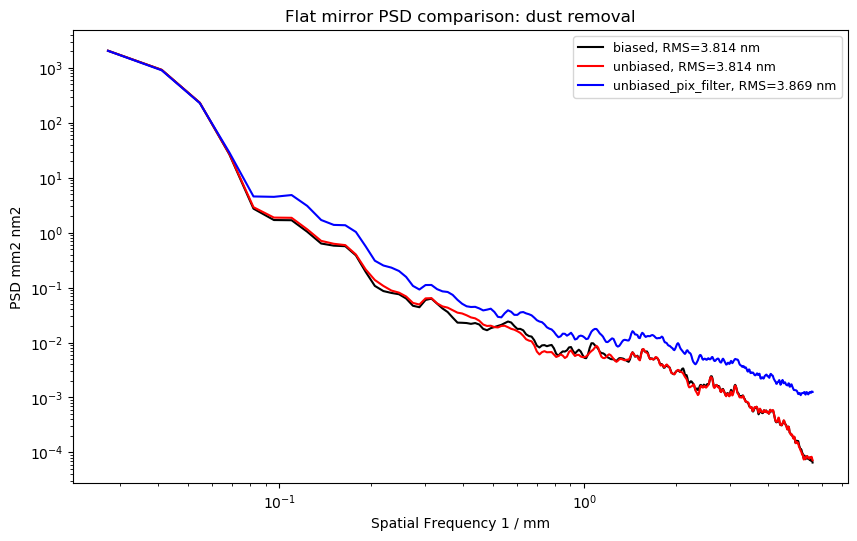

In [211]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, np.sqrt(fm_bias.var)))
plt.loglog(fm_nobias.k_radial.value, fm_nobias.psd_radial_cal.value, 'r', label='{0}, RMS={1:.3f}'.format(fm_nobias.surf_name, np.sqrt(fm_nobias.var)))
plt.loglog(fm_nobias_pix.k_radial.value, fm_nobias_pix.psd_radial_cal.value, 'b', label='{0}, RMS={1:.3f}'.format(fm_nobias_pix.surf_name, np.sqrt(fm_nobias_pix.var)))
plt.xlabel('Spatial Frequency {0}'.format(fm_bias.k_radial.unit))
plt.ylabel('PSD {0}'.format(fm_bias.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})